In [1]:
from cycler import cycler
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from sphincter.data_preparation import load_prepared_data

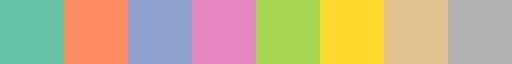

In [2]:
PLOTS_DIR = Path("") / ".." / "plots"
CMAP = plt.get_cmap('Set2')
display(CMAP)
plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)
age_to_color = {"adult": CMAP.colors[0], "old": CMAP.colors[1]}


In [3]:
raw = pd.read_excel("../data/raw/angio-architecture/CapillarySummary_Allcount3.xlsx")
raw.head()

,MouseID,LocID,Condition,Volume,CapOrder,CapVesLL,CapVesNum,CapVesVol,CapVesDiam,CapVesTortous,CapMeanVesLength
0,40520,Loc1,Adult,4.497587e+08,pa,0.000018,1.667561e-07,0.006146,19.656555,1.075209,109.953663
1,40520,Loc1,Adult,4.497587e+08,1stCap,0.000009,1.578624e-07,0.001323,13.960650,1.172599,59.555222
2,40520,Loc1,Adult,4.497587e+08,2ndCap,0.000017,2.912673e-07,0.001923,12.534968,1.153572,56.678658
3,40520,Loc1,Adult,4.497587e+08,3rdCap,0.000031,5.358429e-07,0.002987,11.757314,1.180417,57.003299
4,40520,Loc1,Adult,4.497587e+08,4thCap,0.000048,9.160468e-07,0.004396,11.374330,1.141417,51.982389


In [4]:
data = load_prepared_data("../data/prepared/density.json")
data.measurements.index = map(str, data.measurements.index)

In [5]:
data.measurements

,mouse,age,vessel_type,length_mm,volume_mm3,density_mm_per_mm3
1,40520,adult,cap1,94.015320,4.497587,20.903502
2,40520,adult,cap2,165.086394,4.497587,36.705548
3,40520,adult,cap3,305.448127,4.497587,67.913779
4,40520,adult,cap4,476.182992,4.497587,105.875216
5,40520,adult,cap5,822.944875,4.497587,182.974755
...,...,...,...,...,...,...
139,280420,adult,cap8,971.075942,4.238593,229.103372
140,280420,adult,cap9,682.199761,4.238593,160.949580
141,280420,adult,cap10,484.128233,4.238593,114.219090
142,280420,adult,cap11,291.907579,4.238593,68.868981


In [6]:
data.measurements.groupby("mouse")["age"].first()

/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_53383/577698859.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.measurements.groupby("mouse")["age"].first()


mouse
40520     adult
60520     adult
120419    adult
140120      old
180520    adult
220120      old
230120      old
270220      old
280420    adult
Name: age, dtype: category
Categories (2, object): ['adult' < 'old']

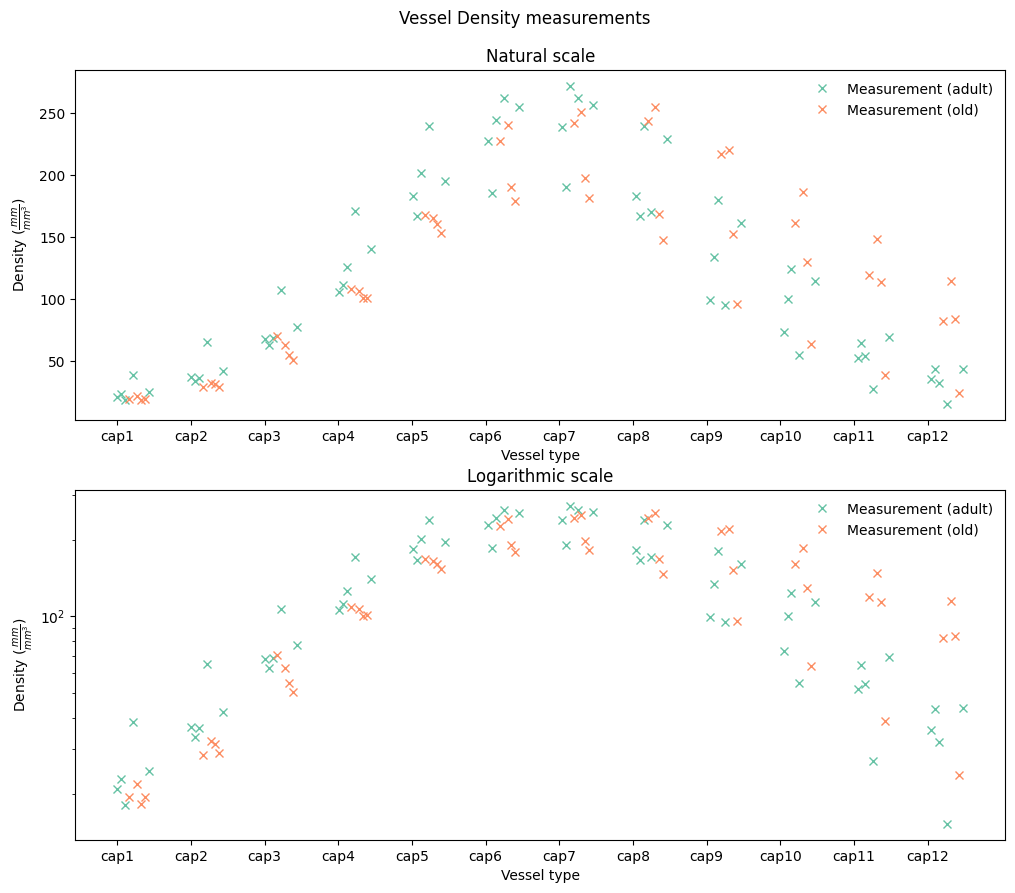

In [7]:
g = (
    data.measurements
    .assign(x=lambda df: df["vessel_type"].cat.codes)
    .groupby(["age", "vessel_type"], observed=True)
)
scts = {}


f, axes = plt.subplots(2, 1, figsize=[12, 10])

for ax in axes:
    for (age, _), df in g:
        for i, row in df.iterrows():
            mrk = ax.plot(
                row["x"] + float(i) / 300, row["density_mm_per_mm3"], 
                marker="x",
                linestyle="None",
                color=age_to_color[age]
            );
            scts[f"Measurement ({age})"] = mrk[0]
    ax.set_xticks(range(len(data.measurements["vessel_type"].cat.categories)), data.measurements["vessel_type"].cat.categories);
    ax.legend(scts.values(), scts.keys(), frameon=False);
    title = "Natural scale" if ax == axes[0] else "Logarithmic scale"
    ax.set(title=title, xlabel="Vessel type", ylabel="Density ($\\frac{mm}{mm^3}$)");
axes[1].semilogy();
f.suptitle("Vessel Density measurements", y=0.94);
f.savefig(PLOTS_DIR / "density-measurements.png", bbox_inches="tight")

In [8]:
idata = az.InferenceData.from_zarr("../inferences/density/idata")
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [9]:
yrep_q = idata.posterior_predictive["yrep"].quantile([0.01, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile")
yrep_q.columns = ["yrep_low", "yrep_high"]
yrep_q

,yrep_low,yrep_high
observation,,
1,17.720141,37.117265
2,30.305949,56.820510
3,54.954882,102.259090
4,99.155174,164.635900
5,151.873680,247.576430
...,...,...
139,130.099490,281.047670
140,79.548855,212.998780
141,48.527681,163.523930


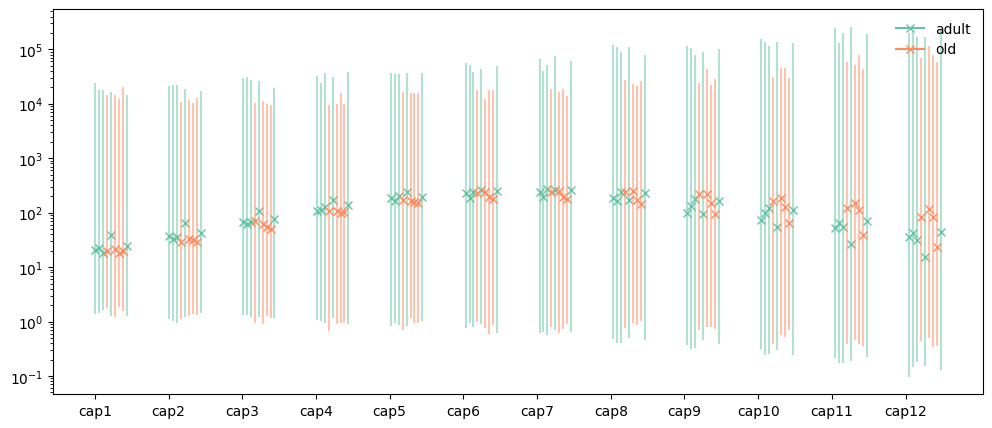

In [10]:
yrep_prior = idata.prior_predictive["yrep"].quantile([0.01, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile")
yrep_prior.columns = ["yrep_low", "yrep_high"]

g = (
    data.measurements
    .join(yrep_prior)
    .assign(x=lambda df: df["vessel_type"].cat.codes)
    .groupby(["age", "vessel_type"], observed=True)
)
scts = {}

f, ax = plt.subplots(figsize=[12, 5])

for (age, _), df in g:
    for i, row in df.iterrows():
        x = row["x"] + float(i) / 300
        mrk = ax.plot(x, row["density_mm_per_mm3"], marker="x", color=age_to_color[age]);
        ax.vlines(x, row["yrep_low"], row["yrep_high"], color=age_to_color[age], alpha=0.5);
        scts[age] = mrk[0]
ax.set_xticks(range(len(data.measurements["vessel_type"].cat.categories)), data.measurements["vessel_type"].cat.categories);
ax.legend(scts.values(), scts.keys(), frameon=False);
ax.semilogy();

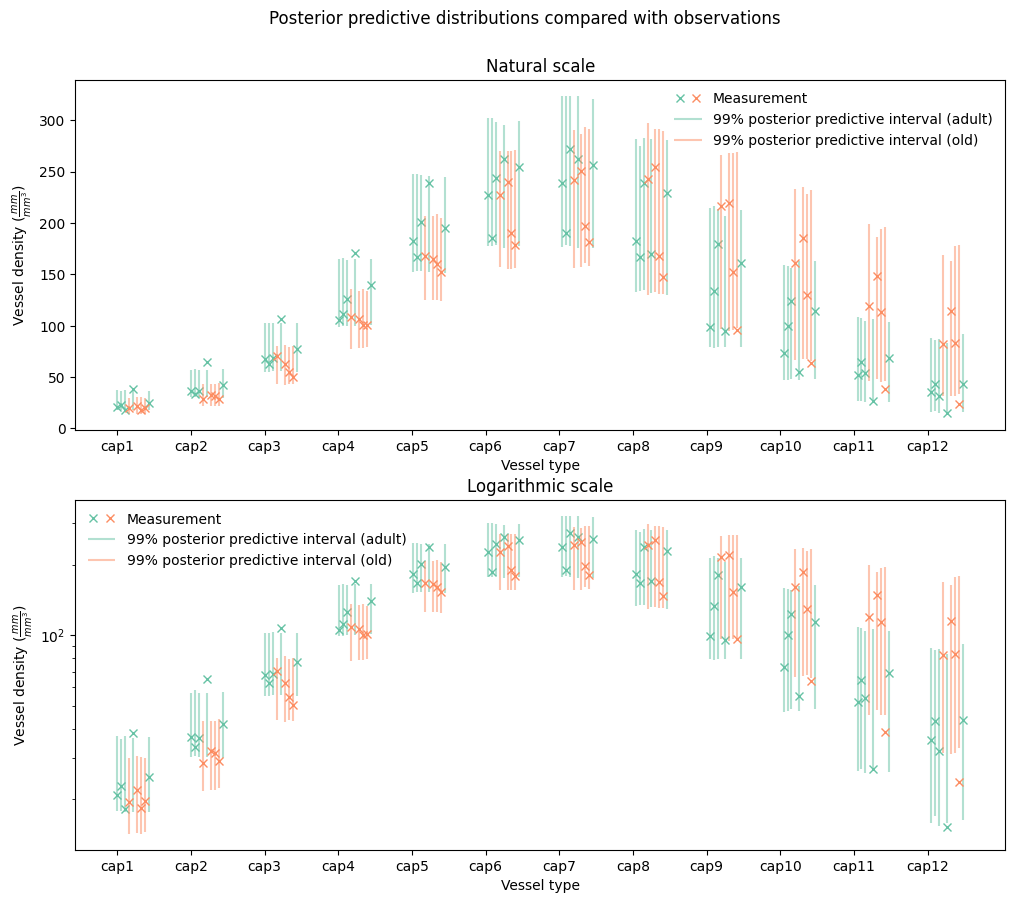

In [11]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

g = (
    data.measurements
    .join(yrep_q)
    .assign(x=lambda df: df["vessel_type"].cat.codes)
    .groupby(["age", "vessel_type"], observed=True)
)

f, axes = plt.subplots(2, 1, figsize=[12, 10])

for ax in axes:
    handles = {"Measurement": {}}
    for (age, _), df in g:
        for i, row in df.iterrows():
            x = row["x"] + float(i) / 300
            mrk = ax.plot(x, row["density_mm_per_mm3"], marker="x", linestyle="None", color=age_to_color[age]);
            vl = ax.vlines(x, row["yrep_low"], row["yrep_high"], color=age_to_color[age], alpha=0.5);
            handles["Measurement"][age] = mrk[0]
            handles[f"99% posterior predictive interval ({age})"] = vl
    if ax == axes[1]:
        ax.semilogy()
    handles["Measurement"] = (handles["Measurement"]["adult"], handles["Measurement"]["old"])
    ax.set_xticks(range(len(data.measurements["vessel_type"].cat.categories)), data.measurements["vessel_type"].cat.categories);
    ax.legend(handles.values(), handles.keys(), frameon=False, handler_map={tuple: HandlerTuple(ndivide=None)});
    title = "Natural scale" if ax == axes[0] else "Logarithmic scale"
    ax.set(title=title, xlabel="Vessel type", ylabel="Vessel density ($\\frac{mm}{mm^3}$)");
f.suptitle("Posterior predictive distributions compared with observations", y=0.95)
f.savefig(PLOTS_DIR / "density-ppc.png", bbox_inches="tight")

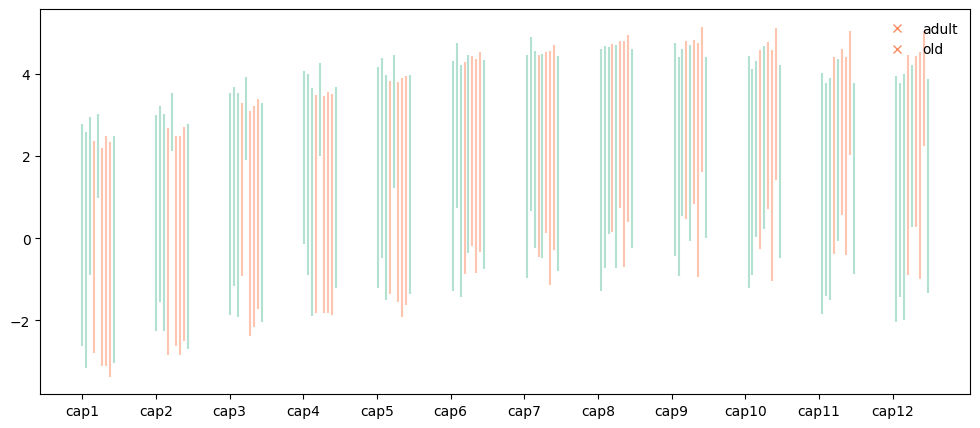

In [12]:
import numpy as np
resid = np.log(np.abs(idata.posterior_predictive["yrep"] - idata.observed_data["y"]))
resid_q = resid.quantile([0.01, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile")
resid_q.columns = ["resid_low", "resid_high"]
g = (
    data.measurements
    .join(resid_q)
    .assign(x=lambda df: df["vessel_type"].cat.codes)
    .groupby(["age", "vessel_type"], observed=True)
)
scts = {}

f, ax = plt.subplots(figsize=[12, 5])

for (age, _), df in g:
    for i, row in df.iterrows():
        x = row["x"] + float(i) / 300
        # mrk = ax.plot(x, row["density_mm_per_mm3"], marker="x", color=age_to_color[age]);
        ax.vlines(x, row["resid_low"], row["resid_high"], color=age_to_color[age], alpha=0.5);
        scts[age] = mrk[0]
ax.set_xticks(range(len(data.measurements["vessel_type"].cat.categories)), data.measurements["vessel_type"].cat.categories);
ax.legend(scts.values(), scts.keys(), frameon=False);

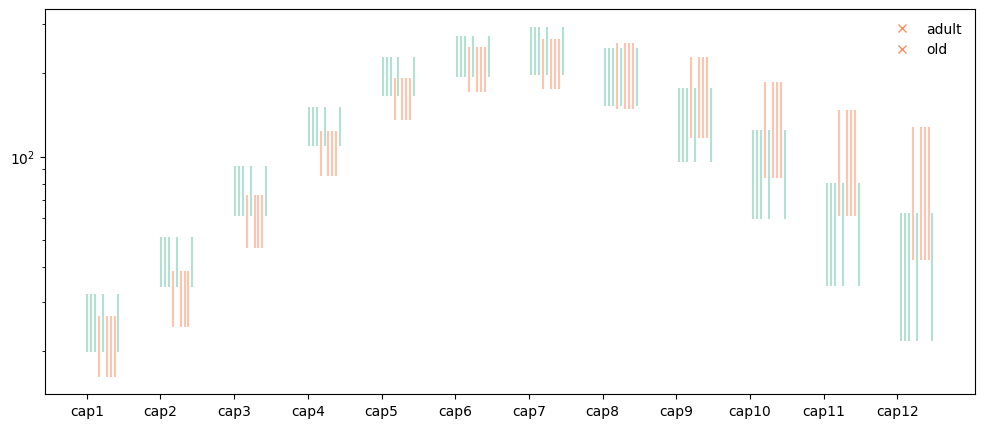

In [13]:
yhat_q = idata.posterior["yhat"].quantile([0.01, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile")
yhat_q.columns = ["yhat_low", "yhat_high"]
g = (
    data.measurements
    .join(yhat_q)
    .assign(x=lambda df: df["vessel_type"].cat.codes)
    .groupby(["age", "vessel_type"], observed=True)
)
scts = {}

f, ax = plt.subplots(figsize=[12, 5])

for (age, _), df in g:
    for i, row in df.iterrows():
        x = row["x"] + float(i) / 300
        # mrk = ax.plot(x, row["density_mm_per_mm3"], marker="x", color=age_to_color[age]);
        ax.vlines(x, row["yhat_low"], row["yhat_high"],  color=age_to_color[age], alpha=0.5);
        scts[age] = mrk[0]
ax.set_xticks(range(len(data.measurements["vessel_type"].cat.categories)), data.measurements["vessel_type"].cat.categories);
ax.legend(scts.values(), scts.keys(), frameon=False);
ax.semilogy();

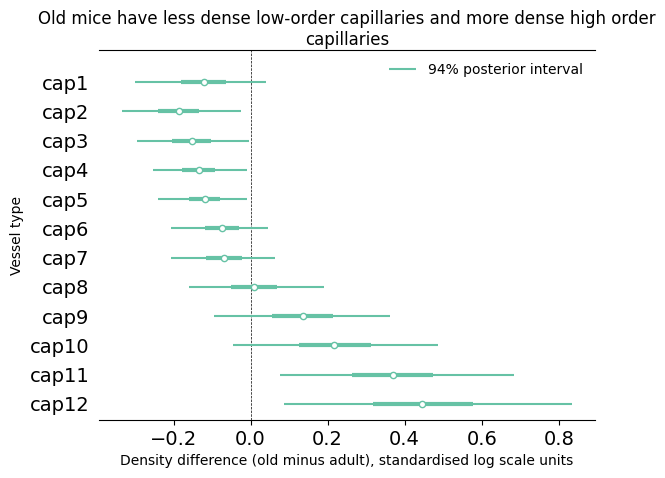

In [14]:
age_effects = (idata.posterior["a_age_vessel_type"]).rename("age_diff")
age_diff = age_effects.sel(age="old") - age_effects.sel(age="adult")

f, ax = plt.subplots()
az.plot_forest(age_diff, combined=True, ax=ax)
ax.axvline(0, color="black", zorder=0, linestyle="--", linewidth=0.5);
l = ax.collections[0]
ax.legend([l], ["94% posterior interval"], frameon=False)
ax.set(
    xlabel="Density difference (old minus adult), standardised log scale units",
    title="Old mice have less dense low-order capillaries and more dense high order capillaries",
    ylabel="Vessel type",
);
yticks = ax.get_yticks()
ax.set_yticks(yticks, list(data.measurements["vessel_type"].cat.categories)[::-1]);
f.savefig(PLOTS_DIR / "density-effects.png", bbox_inches="tight")

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

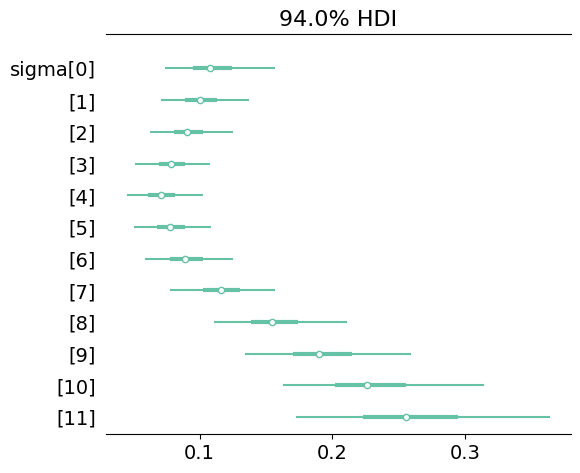

In [15]:
az.plot_forest(idata.posterior["sigma"], combined=True)

In [16]:
az.summary(idata,var_names=["log_sigma_std"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_sigma_std[0],-1.996,0.204,-2.358,-1.619,0.004,0.003,3384.0,2437.0,1.0
log_sigma_std[1],-2.078,0.178,-2.400,-1.749,0.003,0.002,3107.0,2899.0,1.0
log_sigma_std[2],-2.178,0.180,-2.496,-1.821,0.003,0.002,3535.0,2621.0,1.0
log_sigma_std[3],-2.324,0.188,-2.665,-1.948,0.003,0.002,2969.0,2707.0,1.0
log_sigma_std[4],-2.434,0.216,-2.826,-2.020,0.004,0.003,2903.0,2948.0,1.0
log_sigma_std[5],-2.338,0.197,-2.723,-1.975,0.004,0.002,3136.0,2771.0,1.0
log_sigma_std[6],-2.200,0.199,-2.570,-1.835,0.004,0.003,3064.0,3262.0,1.0
log_sigma_std[7],-1.940,0.182,-2.278,-1.589,0.003,0.002,3497.0,2969.0,1.0
log_sigma_std[8],-1.645,0.171,-1.959,-1.327,0.003,0.002,3356.0,2921.0,1.0
log_sigma_std[9],-1.435,0.174,-1.755,-1.104,0.003,0.002,3559.0,2671.0,1.0
